In [87]:
from random import random, randint
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import math
from time import sleep

import numpy.random


class Robot:
    def __init__(self, π_zc = 1, π_zm = 1, π_wm = 1, k = 0.3, speed = 0.01, static = False, gradient = False, periodic = False, upd_c = True, upd_m = True):
        self.sensor_colour = 0 # sensor colour
        self.static_sensor_colour = static # bool to check if sensor is static
        self.gradient_sensor_colour = gradient # bool for gradient
        self.periodic_sensor_colour = periodic
        self.sensor_motor = 0 # sensor motor

        self.belief_colour = 0 # μ colour
        self.update_belief_c = upd_c
        self.belief_motor = 0 # μ motor
        self.update_belief_m = upd_m

        self.pi_z_colour = π_zc # inverse of variance - whatever
        self.pi_z_motor = π_zm # inverse of variance - whatever
        self.pi_w_motor = π_wm # inverse of variance - whatever

        self.k = k # factor k
        self.a = 0 # speed
        self.speed = speed # speed scaling factor

        self.position = 0 # position of robot
        self.free_energy = 0 # F

        # Save for plot
        self.positions = []
        self.free_energies = []
        self.sensor_readings_colour = []
        self.beliefs_colour = []
        self.sensor_readings_motor = []
        self.beliefs_motor = []

    '''
    Main function to simulate one step per call
    '''
    # -- Do one step -- #
    def step(self):
        self.update()
        self.move()
        self.log_data()

    '''
    Updating all values
    '''
    # -- Update step -- #
    def update(self):
        self.update_sensor()
        self.update_belief()
        self.update_a()
        self.update_F()
    # -- Update sensor reading, beliefs, a (speed) and F (free energy) -- #
    def update_sensor(self):
        if self.static_sensor_colour:
            self.sensor_colour = 1
        elif self.gradient_sensor_colour:
            self.sensor_colour = 10 - self.position
        elif self.periodic_sensor_colour:
            self.sensor_colour = math.cos(self.position) + 1.1
        else:
            self.sensor_colour = self.belief_colour #+ numpy.random.normal(0, 1)


        self.sensor_motor = self.a #+ numpy.random.normal(0, 1)
    def update_belief(self):
        old_belief_c = self.belief_colour
        old_belief_m = self.belief_motor
        if self.update_belief_c:
            self.belief_colour += (-self.k) * ((self.pi_z_colour * (old_belief_c - self.sensor_colour)) + (self.pi_w_motor * (old_belief_c - old_belief_m)))
        if self.update_belief_m:
            self.belief_motor += (-self.k) * ((self.pi_z_motor * (old_belief_m - self.sensor_motor)) + (self.pi_w_motor * (old_belief_m - old_belief_c)))
    def update_a(self):
        self.a += (-self.k) * (self.pi_z_motor * (self.sensor_motor - self.belief_motor))
    def update_F(self):
        self.free_energy = 1/2 * ((self.pi_z_colour * math.pow((self.sensor_colour - self.belief_colour), 2)) + self.pi_z_motor * math.pow((self.sensor_motor - self.belief_motor), 2) + self.pi_w_motor * math.pow((self.belief_motor - self.belief_colour), 2))
        print(self.free_energy)

    '''
    Move - just a update position function
    '''
    def move(self):
        self.position += self.speed * self.a

    '''
    Log Position, F, Sensor colour and belief motor
    '''
    def log_data(self):
        #print(f"Robot is at position: {self.position} with free energy: {self.free_energy} and sensor_c: {self.sensor_colour} with μ_c: {self.belief_colour} and sensor_m: {self.sensor_motor} with μ_m: {self.belief_motor}")
        self.positions.append(self.position)
        self.free_energies.append(self.free_energy)
        self.sensor_readings_colour.append(self.sensor_colour)
        self.beliefs_colour.append(self.belief_colour)
        self.sensor_readings_motor.append(self.sensor_motor)
        self.beliefs_motor.append(self.belief_motor)

    def line_plot(self):
        fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

        # Plot Position and Free Energy
        axs[0].plot(self.positions, label='Position', color='blue')
        axs[0].set_ylabel('Position')
        axs[0].legend(loc='upper left')
        ax2 = axs[0].twinx()
        ax2.plot(self.free_energies, label='Free Energy', color='red', linestyle='--')
        ax2.set_ylabel('Free Energy')
        ax2.legend(loc='upper right')
        axs[0].set_title('Position and Free Energy over Time')

        # Plot Sensor Colour and Belief Colour
        axs[1].plot(self.sensor_readings_colour, label='Sensor Colour', color='green')
        axs[1].plot(self.beliefs_colour, label='Belief Colour (μ_c)', color='orange')
        axs[1].set_ylabel('Colour Values')
        axs[1].legend()
        axs[1].set_title('Sensor and Belief (Colour) over Time')

        # Plot Sensor Motor and Belief Motor
        axs[2].plot(self.sensor_readings_motor, label='Sensor Motor', color='purple')
        axs[2].plot(self.beliefs_motor, label='Belief Motor (μ_m)', color='brown')
        axs[2].set_ylabel('Motor Values')
        axs[2].set_xlabel('Timestep')
        axs[2].legend()
        axs[2].set_title('Sensor and Belief (Motor) over Time')

        plt.tight_layout()
        plt.show()






In [80]:
for i in range(1):
    robot = Robot(gradient = True)
    for E in range(6000):
        robot.step()

In [81]:
# 3.1
robot1 = Robot(static=True)
robot2 = Robot(gradient=True)
robot3 = Robot(periodic=True)
for i in range(6000):
    robot1.step()
    robot2.step()
    robot3.step()


## 3.1 k = 0.3 ; π_zc = π_zm = π_wm = 1 ; the standard case
First we see the line plots for static c = 1

Next for gradient 10 - x

Then for periodic cos(x) + 1.1

Line plots for robot with static c = 1


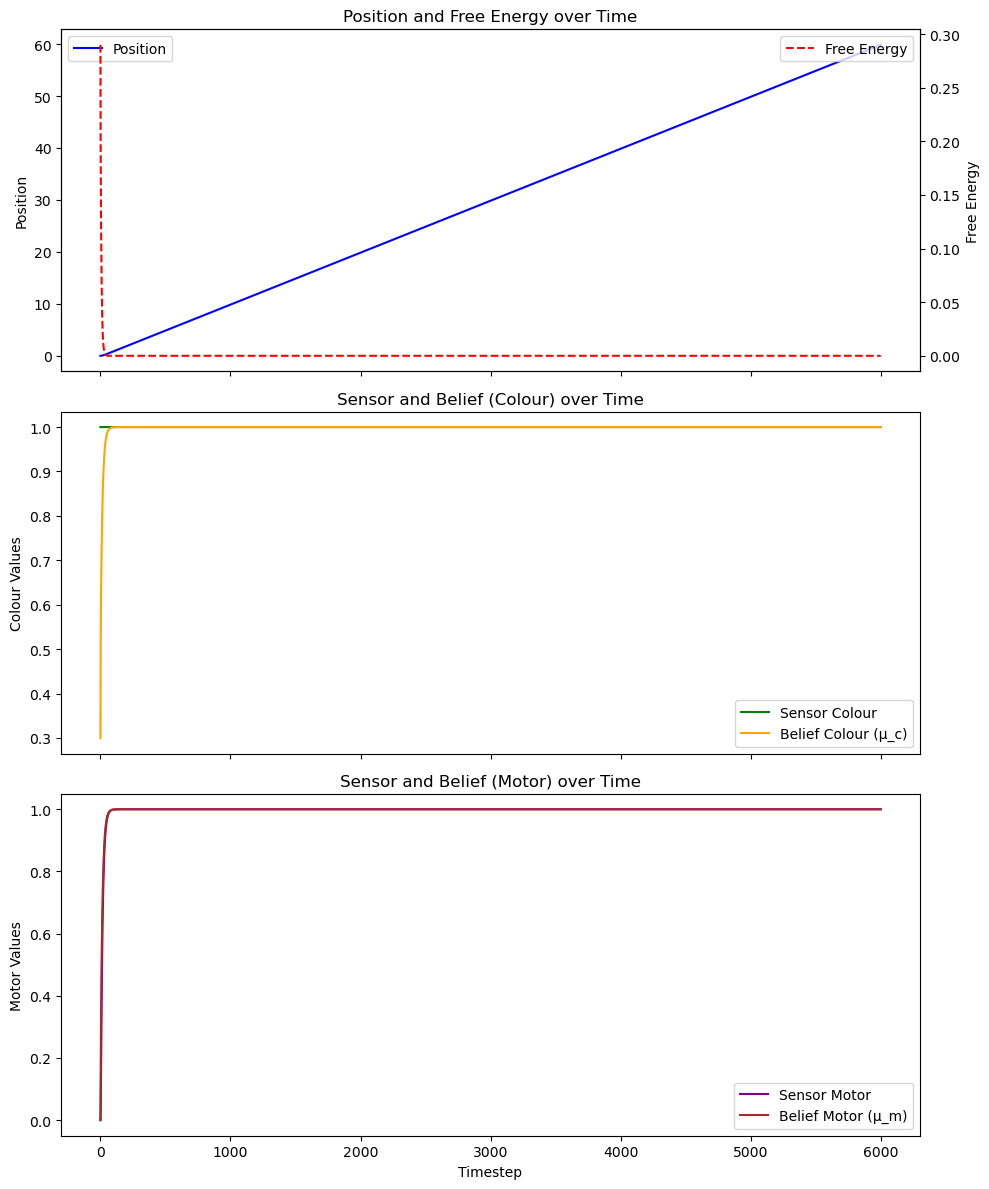

Line plots for robot with gradient c update: 10 - x


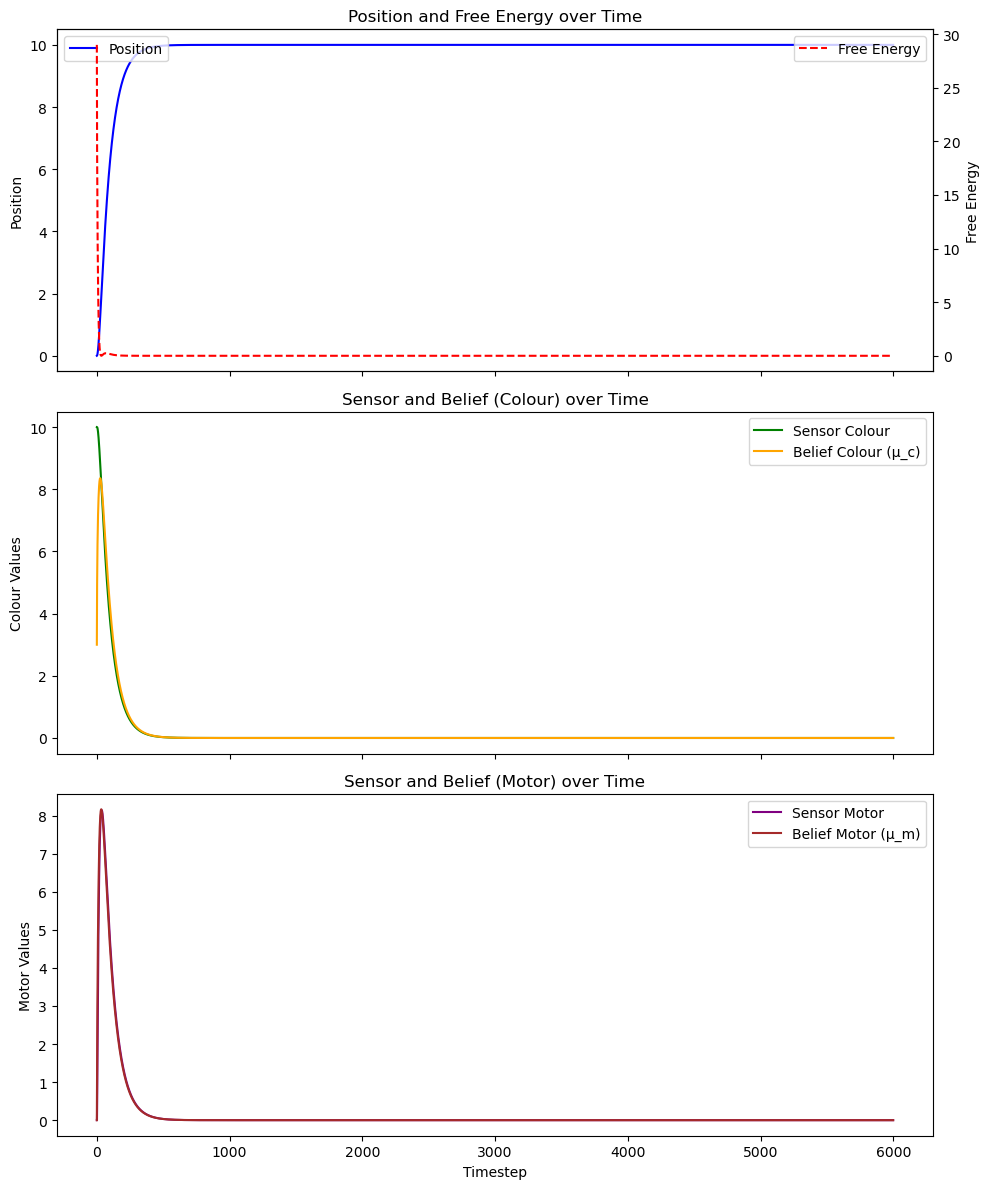

Line plots for robot with periodic c update: cos(x) + 1.1


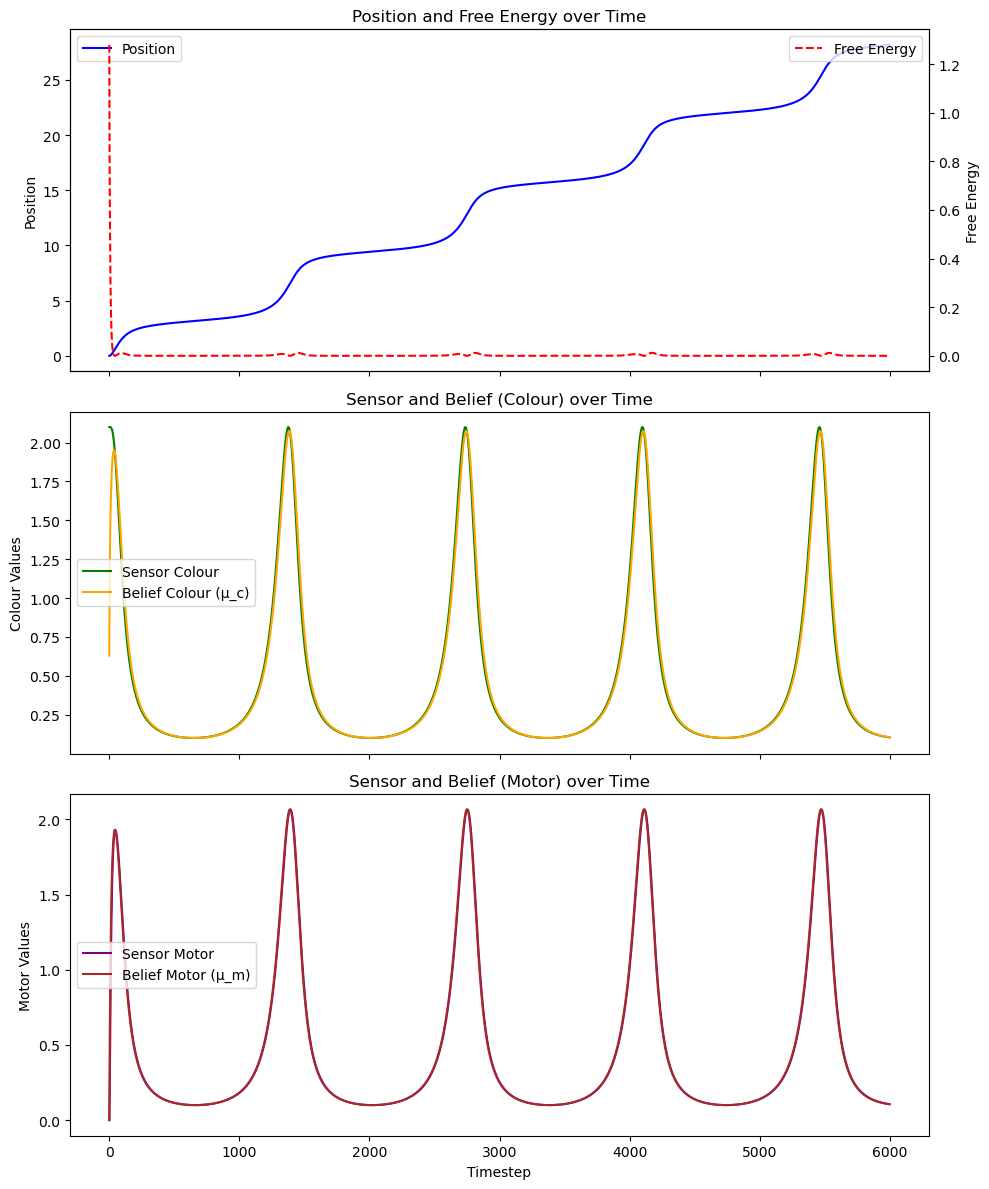

In [82]:
print("Line plots for robot with static c = 1")
robot1.line_plot()
print("Line plots for robot with gradient c update: 10 - x")
robot2.line_plot()
print("Line plots for robot with periodic c update: cos(x) + 1.1")
robot3.line_plot()

## 3.1 k = 0.3 ; π_zc = 0.0001 π_zm = π_wm = 1 ; the robot does not update its belief for µ_c
First we see the line plots for static c = 1

Next for gradient 10 - x

Then for periodic cos(x) + 1.1

In [83]:
#3.2
robot4 = Robot(π_zc=0.0001, static=True, upd_c=False)
robot5 = Robot(π_zc=0.0001, gradient=True, upd_c=False)
robot6 = Robot(π_zc=0.0001, periodic=True, upd_c=False)
for i in range(6000):
    robot4.step()
    robot5.step()
    robot6.step()


Line plots for robot with static c = 1


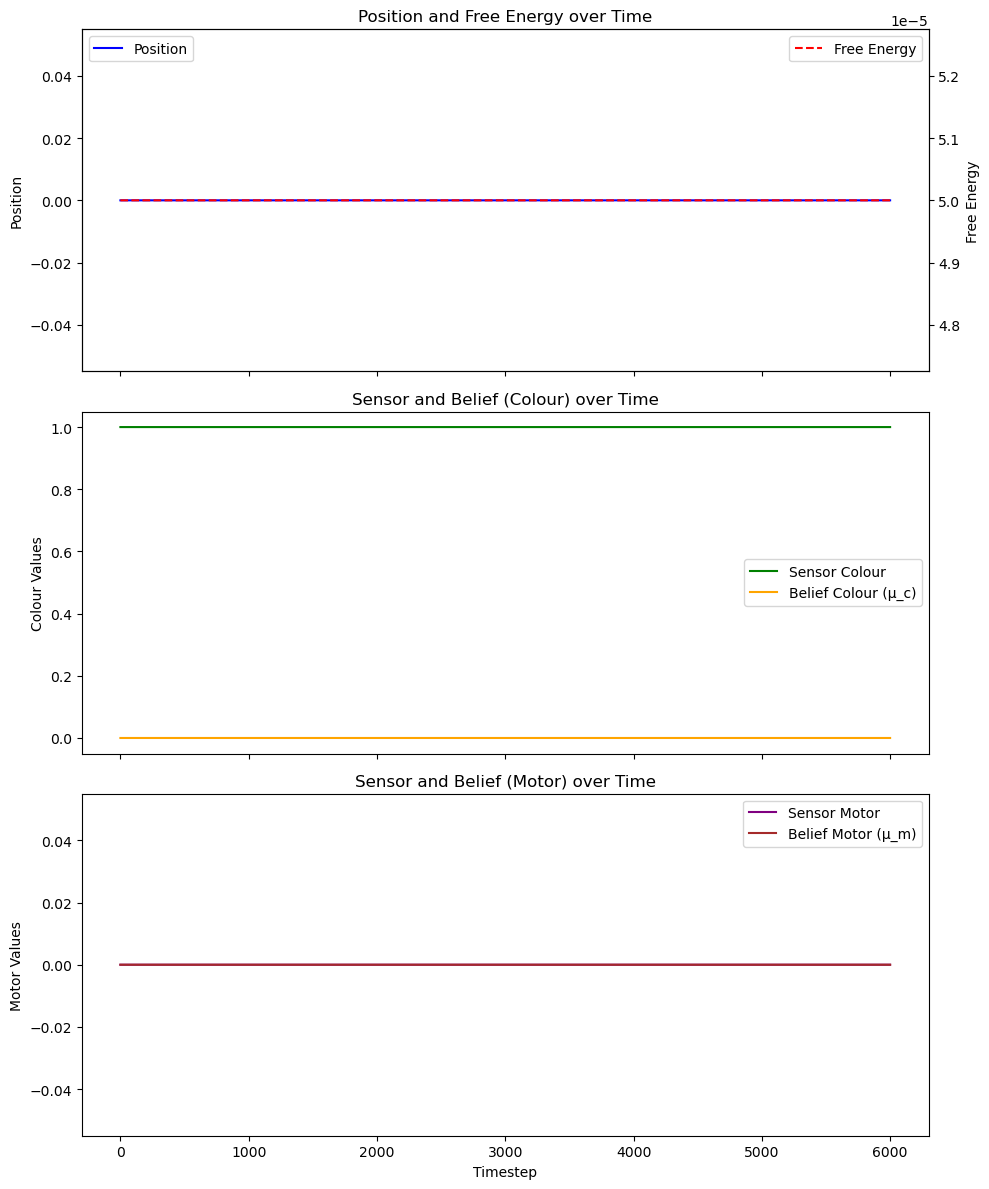

Line plots for robot with gradient c update: 10 - x


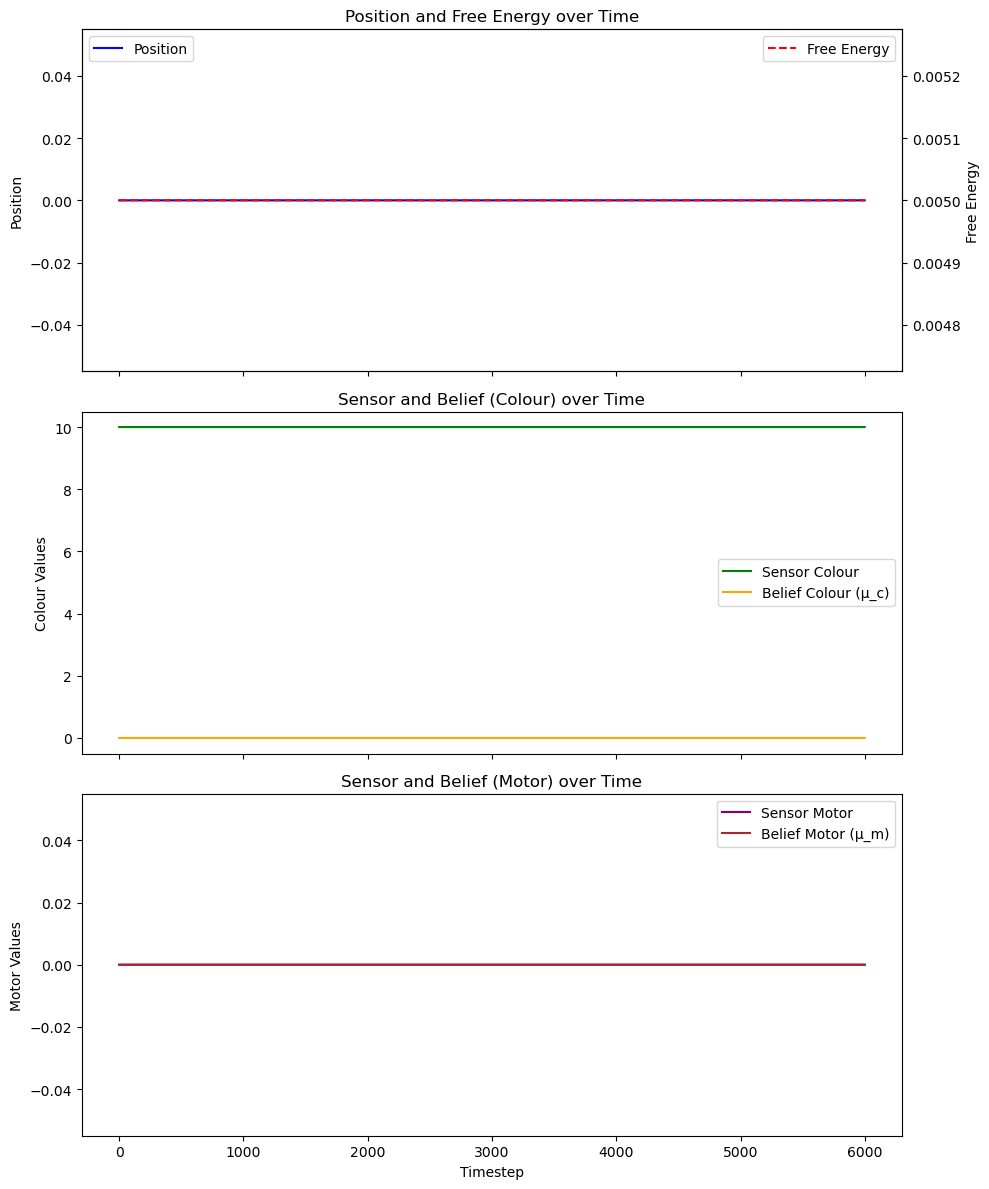

Line plots for robot with periodic c update: cos(x) + 1.1


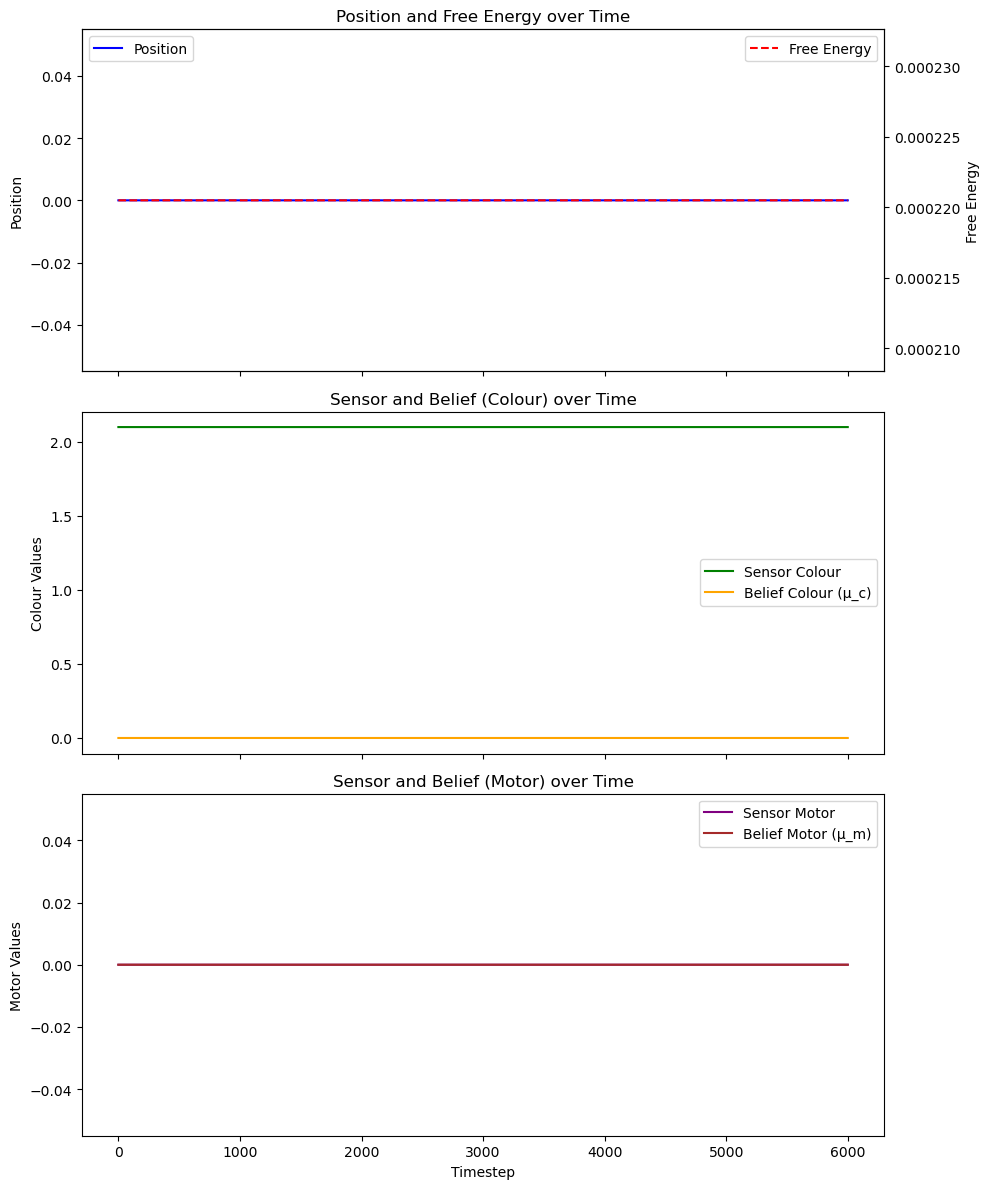

In [84]:
print("Line plots for robot with static c = 1")
robot4.line_plot()
print("Line plots for robot with gradient c update: 10 - x")
robot5.line_plot()
print("Line plots for robot with periodic c update: cos(x) + 1.1")
robot6.line_plot()

## 3.1 k = 0.3 ; π_zm = 0.0001 π_zc = π_wm = 1 ; the robot does not update its belief for µ_m
First we see the line plots for static c = 1

Next for gradient 10 - x

Then for periodic cos(x) + 1.1

In [88]:
#3.3
robot7 = Robot(π_zm=0.0001, static=True, upd_m=False)
robot8 = Robot(π_zm=0.0001, gradient=True, upd_m=False)
robot9 = Robot(π_zm=0.0001, periodic=True, upd_m=False)
for i in range(50):
    #robot7.step()
    robot8.step()
    #robot9.step()

29.0
25.64
25.1024
25.016384
25.00262144
25.0004194304
25.000067108864002
25.00001073741824
25.00000171798692
25.000000274877905
25.000000043980464
25.000000007036874
25.000000001125898
25.000000000180144
25.000000000028823
25.00000000000461
25.00000000000074
25.000000000000117
25.00000000000002
25.000000000000004
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0


Line plots for robot with static c = 1


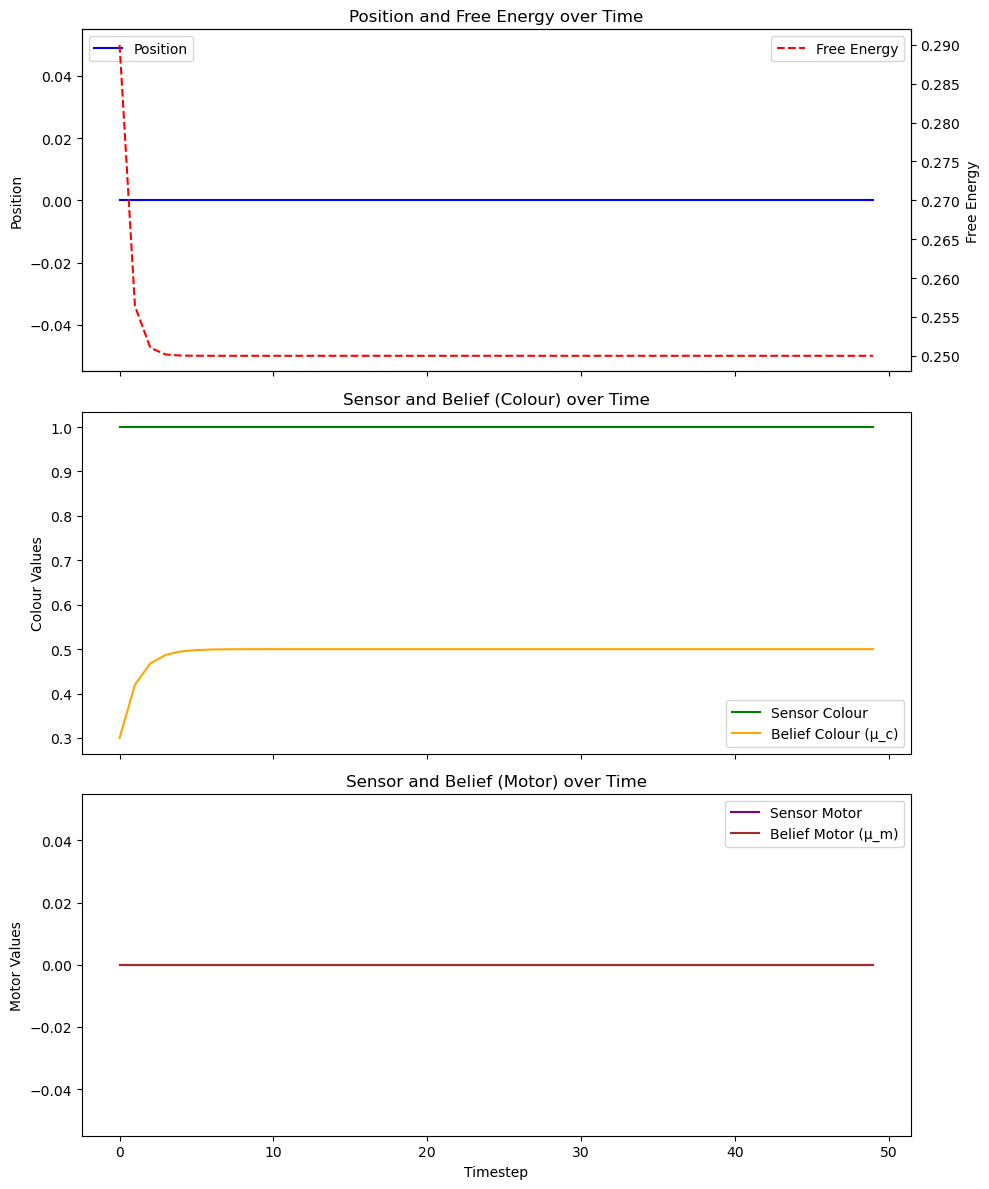

Line plots for robot with gradient c update: 10 - x


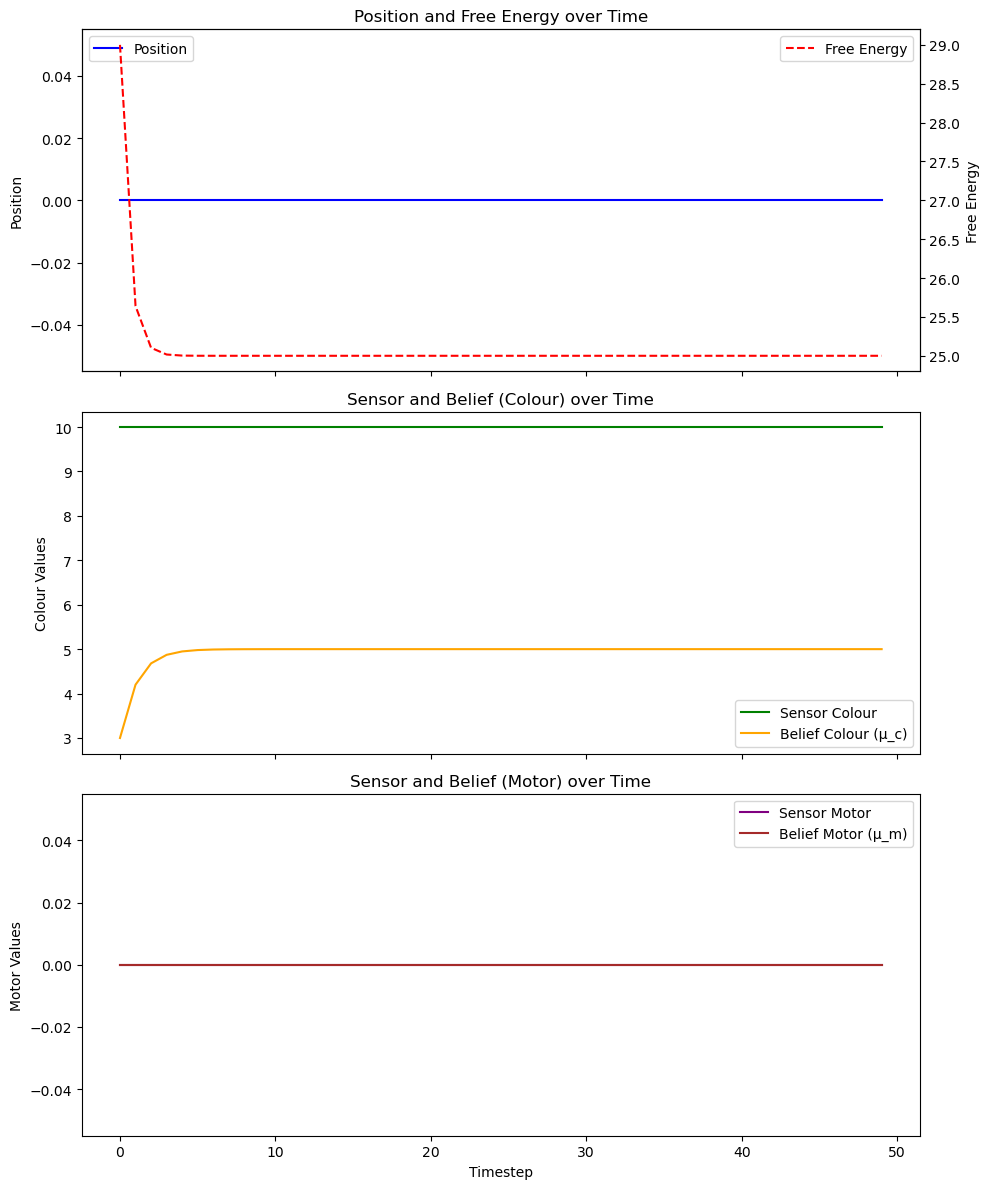

Line plots for robot with periodic c update: cos(x) + 1.1


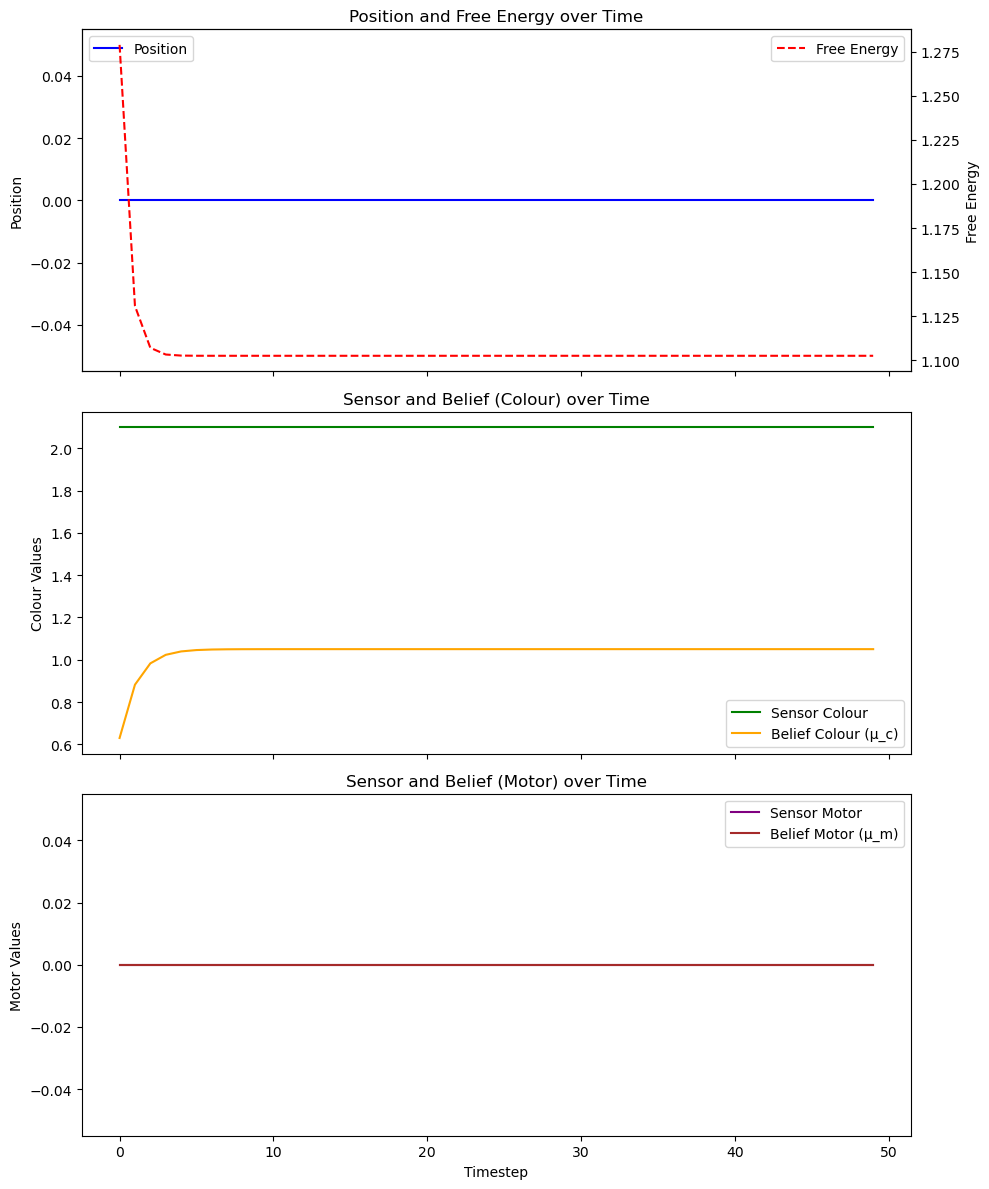

In [86]:
print("Line plots for robot with static c = 1")
#robot7.line_plot()
print("Line plots for robot with gradient c update: 10 - x")
robot8.line_plot()
print("Line plots for robot with periodic c update: cos(x) + 1.1")
#robot9.line_plot()